# SHAP values - what are they?

### Method to explain _predictions_ of ML models, taken from coalitional game theory.
### Idea is it to approximate game theoretically optimal Shapley Values

- retraining model on all feature subsets S ⊆ F, where F is the set of all features.
- a model fS∪{i} is trained with that feature present, and another model fS is trained with the feature withheld
- differences are computed for all possible subsets S ⊆ F \ {i}
- finally, take weighted average of all possible differences.

Can be proved that they are the only additive feature attribution method that satisfies all of:
- local accuracy (explanation matches original model when input is the same)
- missingness (missing features should get importance of 0)
- consistency (if contribution increases, attribution should not decrease)

Other feature importance methods don't satisfy all 3

### Say we're working with the Titanic dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
train = pd.read_csv('data/train.csv')
train_data = train.drop('Survived', axis=1).set_index('PassengerId')
train_target = train.set_index('PassengerId')['Survived']
test_data = pd.read_csv('data/test.csv').set_index('PassengerId')

# encode categorical columns
cat = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
train_data[cat] = train_data[cat].astype('category')
test_data[cat] = test_data[cat].astype('category')

### We train a tree-based classifier:

In [3]:
from lightgbm import LGBMClassifier
import numpy as np
import time
import copy
import seaborn as sns

In [4]:
lgbm = LGBMClassifier(metric='auc', n_estimators=1000)

In [5]:
from sklearn.model_selection import KFold
import shap

cv = KFold(shuffle=True)

In [6]:
oof = pd.Series(index=train_data.index, dtype=int)
predictions = pd.Series(np.zeros(len(test_data)), index=test_data.index, dtype=float)

val_histories = {}
tr_histories = {}

feature_importances = pd.Series(np.zeros(train_data.shape[1]), index=train_data.columns, dtype=float)
explainers = []
test_shap_values = np.zeros(test_data.shape)

for n, (tr_idx, val_idx) in enumerate(cv.split(train_data)):
    lgbm.fit(train_data.iloc[tr_idx], train_target.iloc[tr_idx],
             early_stopping_rounds=100,
             eval_metric='auc',
             eval_set=[(train_data.iloc[tr_idx], train_target.iloc[tr_idx]), (train_data.iloc[val_idx], train_target.iloc[val_idx])],
             verbose=100
            )
    predictions += lgbm.predict(test_data)
    val_histories[f'fold_{n}'] = lgbm.evals_result_['valid_1']['auc']
    tr_histories[f'fold_{n}'] = lgbm.evals_result_['valid_0']['auc']
    feature_importances += lgbm.feature_importances_
    
    explainer = shap.TreeExplainer(lgbm)
    explainers.append(explainer)
    test_shap_values += explainer.shap_values(test_data)[1]
    
predictions /=cv.n_splits
predictions = predictions.astype(int)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.991073	valid_1's auc: 0.872412
Early stopping, best iteration is:
[47]	valid_0's auc: 0.969173	valid_1's auc: 0.889141


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.991584	valid_1's auc: 0.85873
Early stopping, best iteration is:
[18]	valid_0's auc: 0.93071	valid_1's auc: 0.881812
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.993068	valid_1's auc: 0.845033
Early stopping, best iteration is:
[68]	valid_0's auc: 0.985604	valid_1's auc: 0.847275
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.993259	valid_1's auc: 0.847049
Early stopping, best iteration is:
[12]	valid_0's auc: 0.926692	valid_1's auc: 0.868563
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.992595	valid_1's auc: 0.873972
Early stopping, best iteration is:
[8]	valid_0's auc: 0.921103	valid_1's auc: 0.888843


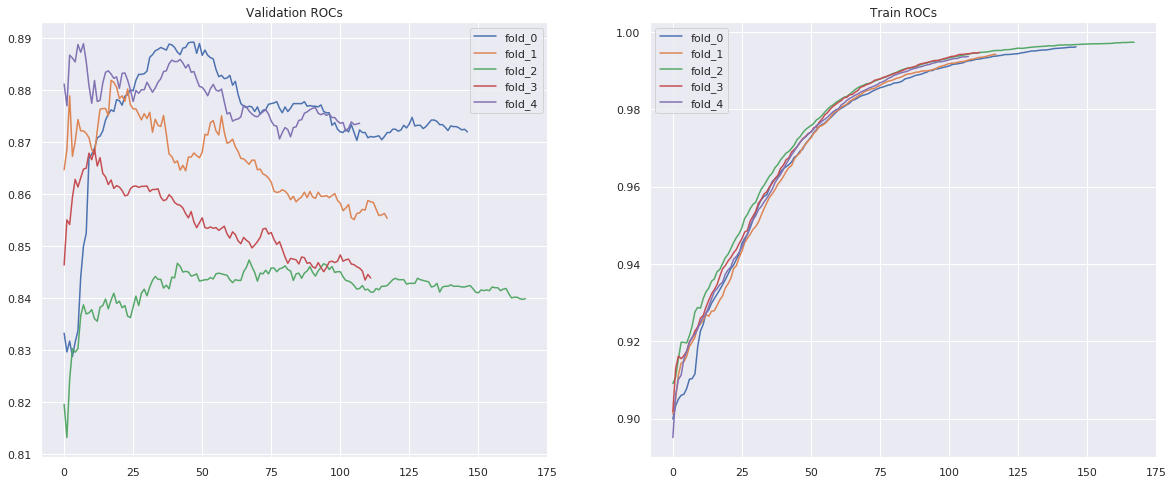

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for key, val in val_histories.items():
    ax[0].plot(val, label=key)
ax[0].set_title('Validation ROCs')
ax[0].legend()

for key, val in tr_histories.items():
    ax[1].plot(val, label=key)
ax[1].set_title('Train ROCs')
ax[1].legend()

### Which features were most important? Let's look at feature importances

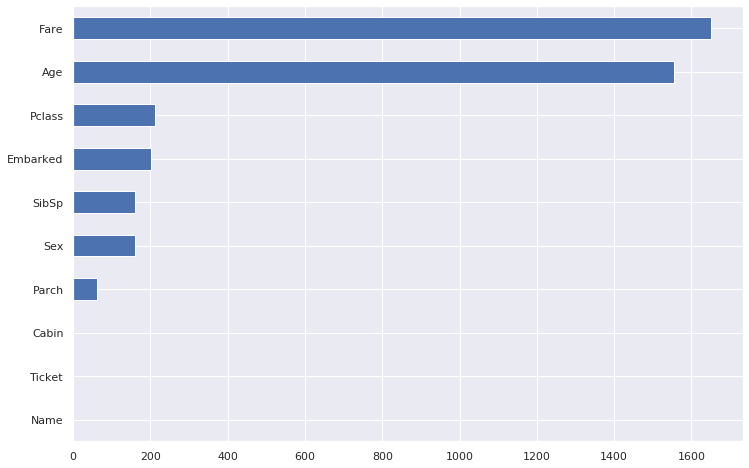

In [8]:
feature_importances.sort_values().plot(kind='barh', figsize=(12, 8));

### Somehow, it doesn't look quite right that sex is so low

### Let's try something else - SHAP values.

In [9]:
shap.initjs()

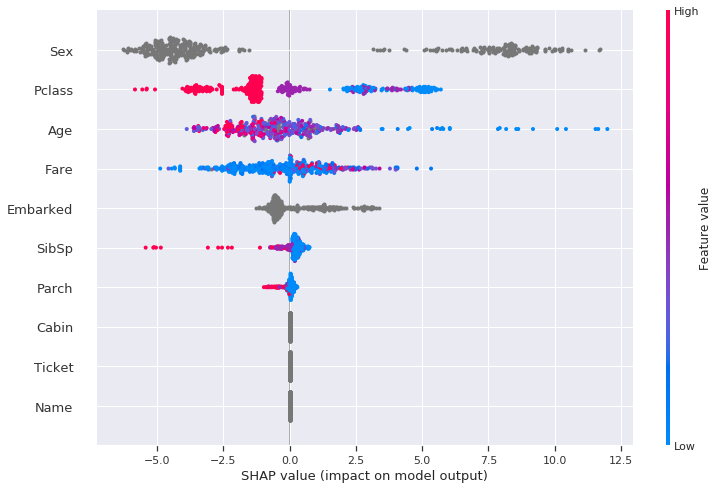

In [10]:
shap.summary_plot(test_shap_values, test_data, plot_size=(12, 8))

### Right. Now, let's look at a single instance of a prediction

In [11]:
test_data.iloc[5]

Pclass                               3
Name        Svensson, Mr. Johan Cervin
Sex                               male
Age                                 14
SibSp                                0
Parch                                0
Ticket                            7538
Fare                             9.225
Cabin                              NaN
Embarked                             S
Name: 897, dtype: object

### What did our model predict?

In [12]:
predictions.iloc[5]

0

### Not survived. How can we explain that? Feature importances here would tell us nothing, as they are only calculated from training.

## But SHAP values can tell us something useful:

In [13]:
shap.force_plot(np.mean([i.expected_value[1] for i in explainers]), test_shap_values[5, :], test_data.columns, figsize=(20, 10))